### Classificação de nomes usando Redes Neurais Recorrentes (RNN)

Uma rede neural recorrente (RNN) é uma classe de redes neurais que inclui conexões ponderadas dentro de uma camada (em comparação com as redes de feed-forward tradicionais, onde conecta alimentação apenas camadas subsequentes).

Como as RNNs incluem loops, elas podem armazenar informações ao processar novas entradas. Essa memória os torna ideais para tarefas de processamento onde as entradas anteriores devem ser consideradas.

Uso:<br/>
 - Séries temporais.
 - Análise de sentimento de textos.
 - Traduções.
 - Reconhecimento de fala.
 - Composições de músicas.

Vamos construir uma RNN usando a biblioteca __[Pytorch](https://pytorch.org/)__ e treiná-la com alguns milhares de sobrenomes de 18 idiomas diferentes e depois prever a qual idioma um nome pertence baseado em sua grafia.

**_Referências:_**<br/>
_Tutorial de Sean Robertson <https://github.com/spro/practical-pytorch>_<br/>
_https://imasters.com.br/data/um-mergulho-profundo-nas-redes-neurais-recorrentes_<br/>
_https://en.wikipedia.org/wiki/Tensor_

In [1]:
%matplotlib inline

### Preparando os dados

Aqui os datasets com os dados de treinamento serão carregados em memória e reorganizados, por exemplo, criando _dicionários_ de nomes por idioma (language: [names ...]) para uso posterior.

(_Dados usados no tutorial: https://download.pytorch.org/tutorial/data.zip_)

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Chinese.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Greek.txt', 'data/names/German.txt', 'data/names/Polish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Dutch.txt', 'data/names/Spanish.txt', 'data/names/Irish.txt', 'data/names/Vietnamese.txt', 'data/names/French.txt', 'data/names/English.txt']
Slusarski


Agora temos ``category_lines``, um dicionário que mapeia cada categoria
(language) a uma lista de linhas (names). Mantemos também a variável
``all_categories`` (simplesmente uma lista de 'languages') e ``n_categories`` para referência posterior.

In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Transformando Nomes em Tensores

Agora que temos todos os nomes organizados, vamos transformá-los em
Tensores.

_Tensores são estruturas de dados que representam entidades geométricas introduzidas na matemática e na física para generalizar a noção de escalares, vetores e matrizes. Assim como tais entidades, um tensor é uma forma de representação associada a um conjunto de operações tais como a soma e o produto_

In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Criando a Rede

Fase onde as camadas são criadas.

Em resumo: nesta fase é onde a RNN será criada e as camadas são retroalimentadas 

<img src="https://i.imgur.com/Z2xbySO.png" title="RNN" />

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8010, -2.8507, -2.8373, -2.9528, -2.9563, -2.9486, -2.9998, -2.7900,
         -2.9097, -2.8623, -2.8383, -2.9180, -2.9622, -2.9654, -2.8098, -2.8805,
         -2.9798, -2.8058]], grad_fn=<LogSoftmaxBackward>)


### Funções que serão usadas no treinamento

In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

('Greek', 7)
category = Vietnamese / line = Vu
category = Spanish / line = Rodriguez
category = Vietnamese / line = Phi
category = Japanese / line = Arato
category = Spanish / line = Viteri
category = Polish / line = Paszek
category = Greek / line = Sortras
category = Arabic / line = Saliba
category = Japanese / line = Kuroda
category = German / line = Bischoffs


### Treinando a rede

Cada ciclo de treinamento irá:

 - Criar tensores de entrada e de destino
 - Criar um estado oculto inicial zerado
 - Ler cada letra e
  - Manter o estado oculto para a próxima letra
 - Comparar a saída final com o objetivo
 - Voltar propagar
 - Retornar a saída e a perda

In [7]:
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

import time
import math

n_iters = 10000
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 2s) 2.9104 Kang / German ✗ (Korean)
1000 10% (0m 4s) 2.9015 Vuu / Chinese ✗ (Vietnamese)
1500 15% (0m 6s) 2.6452 Schneiders / Greek ✗ (Dutch)
2000 20% (0m 8s) 2.9439 Altman / Chinese ✗ (Russian)
2500 25% (0m 10s) 2.8566 Michel / German ✗ (French)
3000 30% (0m 12s) 3.0634 Gwock / Czech ✗ (Chinese)
3500 35% (0m 14s) 2.7732 Sheehy / English ✗ (Irish)
4000 40% (0m 15s) 2.5090 Arihyoshi / Italian ✗ (Japanese)
4500 45% (0m 17s) 2.8919 Piovene / French ✗ (Italian)
5000 50% (0m 19s) 3.1613 Yakush / Portuguese ✗ (Russian)
5500 55% (0m 21s) 1.9432 Iwahara / Japanese ✓
6000 60% (0m 23s) 2.7588 Langenberg / Irish ✗ (German)
6500 65% (0m 25s) 1.8617 Marszaek / Czech ✗ (Polish)
7000 70% (0m 27s) 2.8505 Boyle / Arabic ✗ (Scottish)
7500 75% (0m 29s) 1.7423 Jamieson / Russian ✗ (Scottish)
8000 80% (0m 31s) 2.2711 Cerney / Czech ✓
8500 85% (0m 33s) 2.2618 Hofwegen / Dutch ✓
9000 90% (0m 35s) 1.2914 Yuan / Chinese ✓
9500 95% (0m 37s) 2.9031 Bell / Chinese ✗ (Scottish)
10000 100% (0m 39s) 2.300

### Plotar os resultados

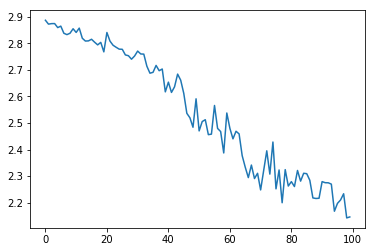

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Avaliação

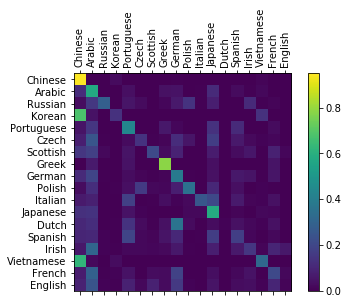

In [9]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Testes

In [10]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [11]:
predict('Medeiros')


> Medeiros
(-1.01) Greek
(-2.20) Portuguese
(-2.82) Spanish


In [12]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.92) Polish
(-2.12) Czech
(-2.44) English

> Jackson
(-2.02) Scottish
(-2.28) Irish
(-2.33) English

> Satoshi
(-2.07) Japanese
(-2.24) Polish
(-2.26) Italian


In [13]:
predict('Costa')


> Costa
(-1.96) Spanish
(-2.17) Arabic
(-2.21) Japanese


In [14]:
predict('Silva')


> Silva
(-2.00) Spanish
(-2.14) Arabic
(-2.25) Portuguese
